In [68]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import torch
import random
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from EEG_transformer_code.method_A.model import EEGT
import EEG_transformer_code.method_A.params_full_c as params
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
warnings.filterwarnings('ignore')

Num GPUs Available:  3


# Configurations

In [69]:
data_path = './dataset'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
cross = 20
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

cuda:1


# SVM

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [71]:
data_list = os.listdir(data_path)
acc_tests_SVM = []
f1_tests_SVM = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        classifier = svm.SVC(C=1,kernel='rbf')
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
        # if i == cross-1:
        #     plot_confusion_matrix(test_label.tolist(), classifier.predict(test_data).tolist(), ['0', '1'], False, 'SVM')
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_SVM.append(acc_test*100)
    f1_tests_SVM.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.96874
F1 of test set: 0.98397
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97488
F1 of test set: 0.98726
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.84771
F1 of test set: 0.91536
Begin to process person liangjie_20210424_2.
Acc of test set: 0.74704
F1 of test set: 0.83031
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.76953
F1 of test set: 0.86078
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.78815
F1 of test set: 0.87124
Begin to process person tana_20210425_1.
Acc of test set: 0.97897
F1 of test set: 0.98935
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.77345
F1 of test set: 0.85647
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.87941
F1 of test set: 0.93412
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.77303
F1 of test set: 0.85989
Begin to process person zhengwenxin_20210429_2.
Acc 

# Logistic Regression

In [72]:
data_list = os.listdir(data_path)
acc_tests_LR = []
f1_tests_LR = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label, test_data, test_label = traindata[:,:-1], traindata[:,-1], testdata[:,:-1], testdata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        classifier = LogisticRegression(penalty="l2", C=0.5, solver="liblinear")
        classifier.fit(train_data, train_label)
        tests.append(classifier.score(test_data, test_label))
        tests_f1.append(f1_score(test_label, classifier.predict(test_data)))
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_LR.append(acc_test*100)
    f1_tests_LR.append(f1_test*100)

Begin to process person huangsiye_20210529_1.
Acc of test set: 0.97923
F1 of test set: 0.98942
Begin to process person huangsiye_20210531_2.
Acc of test set: 0.97110
F1 of test set: 0.98530
Begin to process person huangsiye_20210604_3.
Acc of test set: 0.92618
F1 of test set: 0.96136
Begin to process person liangjie_20210424_2.
Acc of test set: 0.81631
F1 of test set: 0.88976
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 0.80359
F1 of test set: 0.88482
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 0.81436
F1 of test set: 0.89309
Begin to process person tana_20210425_1.
Acc of test set: 0.96985
F1 of test set: 0.98465
Begin to process person zengcheng_20210615_1.
Acc of test set: 0.79057
F1 of test set: 0.87273
Begin to process person zengjingyao_20210604_2.
Acc of test set: 0.88836
F1 of test set: 0.93946
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 0.83754
F1 of test set: 0.90792
Begin to process person zhengwenxin_20210429_2.
Acc 

# Multi-layer Perceptron

In [73]:
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(310, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [74]:
def Validation(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100, f1 * 100

In [75]:
data_list = os.listdir(data_path)
acc_tests_MLP = []
f1_tests_MLP = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_MLP.append(acc_test)
    f1_tests_MLP.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 78.58959
F1 of test set: 78.52737
Begin to process person huangsiye_20210531_2.
Acc of test set: 78.57285
F1 of test set: 76.21223
Begin to process person huangsiye_20210604_3.
Acc of test set: 77.17324
F1 of test set: 78.09325
Begin to process person liangjie_20210424_2.
Acc of test set: 80.82105
F1 of test set: 89.17585
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 81.82297
F1 of test set: 87.70821
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 77.45122
F1 of test set: 79.89809
Begin to process person tana_20210425_1.
Acc of test set: 83.33615
F1 of test set: 84.38413
Begin to process person zengcheng_20210615_1.
Acc of test set: 82.34777
F1 of test set: 84.53197
Begin to process person zengjingyao_20210604_2.
Acc of test set: 83.77640
F1 of test set: 84.98710
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 83.86032
F1 of test set: 87.85900
Begin to process person zhengwen

# Convolution Neural Network

In [76]:
class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN, self).__init__()
        # self.feature_extraction = nn.Sequential(
        #     nn.Conv1d(in_channels = 1, out_channels = 2, kernel_size = 16, padding = 1),
        #     nn.MaxPool1d(kernel_size = 8, stride = 1),
        #     nn.ReLU(),
        #     nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 16),
        #     nn.Conv1d(in_channels = 2, out_channels = 4, kernel_size = 16, padding = 1),
        #     nn.ReLU()
        # )  
        # self.classifier = nn.Sequential(
        #     nn.Linear(1048, 2048),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(2048, num_classes)
        # )
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = 4, padding = 1),
            nn.MaxPool1d(kernel_size = 4, stride = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.ReLU()
        )  
        self.classifier = nn.Sequential(
            nn.Linear(1728, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [77]:
data_list = os.listdir(data_path)
acc_tests_CNN = []
f1_tests_CNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5).permute(0, 2, 1)
        test_data = test_data.reshape(test_data.shape[0], 62, 5).permute(0, 2, 1)
        # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1).permute(0, 2, 1)
        # test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1).permute(0, 2, 1)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_CNN.append(acc_test)
    f1_tests_CNN.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.61997
F1 of test set: 98.48220
Begin to process person huangsiye_20210531_2.
Acc of test set: 90.33889
F1 of test set: 90.72957
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.56458
F1 of test set: 97.47990
Begin to process person liangjie_20210424_2.
Acc of test set: 82.75751
F1 of test set: 89.49304
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 84.14867
F1 of test set: 82.66069
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 83.29956
F1 of test set: 86.88831
Begin to process person tana_20210425_1.
Acc of test set: 92.84119
F1 of test set: 93.86326
Begin to process person zengcheng_20210615_1.
Acc of test set: 81.66578
F1 of test set: 86.30953
Begin to process person zengjingyao_20210604_2.
Acc of test set: 88.26494
F1 of test set: 91.81428
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 84.61814
F1 of test set: 88.18533
Begin to process person zhengwen

# Recurrent Neural Network

In [108]:
class RNN(nn.Module):
    def __init__(self, hidden_size = 32, num_classes = 2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = 5, hidden_size = self.hidden_size, num_layers = 2, batch_first = True, bidirectional = True)
        self.classifier = nn.Sequential(
            nn.Linear(62 * self.hidden_size * 2, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [109]:
data_list = os.listdir(data_path)
acc_tests_RNN = []
f1_tests_RNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = RNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_RNN.append(acc_test)
    f1_tests_RNN.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 98.00269
F1 of test set: 98.82489
Begin to process person huangsiye_20210531_2.
Acc of test set: 97.95913
F1 of test set: 98.88514
Begin to process person huangsiye_20210604_3.
Acc of test set: 95.66293
F1 of test set: 98.27340
Begin to process person liangjie_20210424_2.
Acc of test set: 78.54034
F1 of test set: 73.85429
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 84.16632
F1 of test set: 89.61806
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 88.42855
F1 of test set: 91.56705
Begin to process person tana_20210425_1.
Acc of test set: 98.05518
F1 of test set: 99.37649
Begin to process person zengcheng_20210615_1.
Acc of test set: 85.79466
F1 of test set: 84.85234
Begin to process person zengjingyao_20210604_2.
Acc of test set: 96.08522
F1 of test set: 97.19592
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 89.65353
F1 of test set: 91.95217
Begin to process person zhengwen

# Transformer

In [110]:
def define_model(i):
    return EEGT(
        params.ENC_INPUT_LEN,
        params.CLASSES,
        params.ENC_INPUT_DIM,
        params.ENC_DEPTH[i],
        params.ENC_HEADS,
        params.ENC_MLP_DIM[i],
        params.ENC_POOL,
        params.ENC_DIM_HEAD[i],
        params.ENC_DROPOUT,
        params.ENC_EMB_DROPOUT,
    )

In [112]:
data_list = os.listdir(data_path)
acc_tests_Transformer = []
f1_tests_Transformer = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    tests, tests_f1 = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = traindata[:,:-1], traindata[:,-1]
        train_data, train_label = SMOTE(k_neighbors=1).fit_resample(train_data, train_label)
        train_data, train_label = torch.from_numpy(train_data).float(), torch.from_numpy(train_label)
        test_data, test_label = testdata[:,:-1], testdata[:,-1]
        test_data, test_label = torch.from_numpy(test_data).float(), torch.from_numpy(test_label)
        train_data = train_data.reshape(train_data.shape[0], 62, 5)
        test_data = test_data.reshape(test_data.shape[0], 62, 5)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = define_model(0).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 20
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                net.train()
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
                # print("Train Epoch: {} of {} [{} of {}] Loss: {:.5f}".format(epoch+1, epoches, i+1, len(train_loader), loss.item()))
        acc, f1 = Validation(net=net, testloader=test_loader)
        tests.append(acc)
        tests_f1.append(f1)
    acc_test, f1_test = np.mean(tests), np.mean(tests_f1)
    print("Acc of test set: {:.5f}".format(acc_test))
    print("F1 of test set: {:.5f}".format(f1_test))
    acc_tests_Transformer.append(acc_test)
    f1_tests_Transformer.append(f1_test)

Begin to process person huangsiye_20210529_1.
Acc of test set: 97.82100
F1 of test set: 98.42927
Begin to process person huangsiye_20210531_2.
Acc of test set: 97.79132
F1 of test set: 98.20194
Begin to process person huangsiye_20210604_3.
Acc of test set: 96.01785
F1 of test set: 98.59824
Begin to process person liangjie_20210424_2.
Acc of test set: 83.30753
F1 of test set: 89.76643
Begin to process person liuzhiwei_20210608_1.
Acc of test set: 85.38680
F1 of test set: 85.42177
Begin to process person liuzhiwei_20210611_2.
Acc of test set: 82.82123
F1 of test set: 84.53086
Begin to process person tana_20210425_1.
Acc of test set: 97.16085
F1 of test set: 99.00020
Begin to process person zengcheng_20210615_1.
Acc of test set: 83.97285
F1 of test set: 88.88988
Begin to process person zengjingyao_20210604_2.
Acc of test set: 93.64177
F1 of test set: 96.63126
Begin to process person zhengwenxin_20210415_1.
Acc of test set: 89.08609
F1 of test set: 94.71798
Begin to process person zhengwen

# Comparison of different models

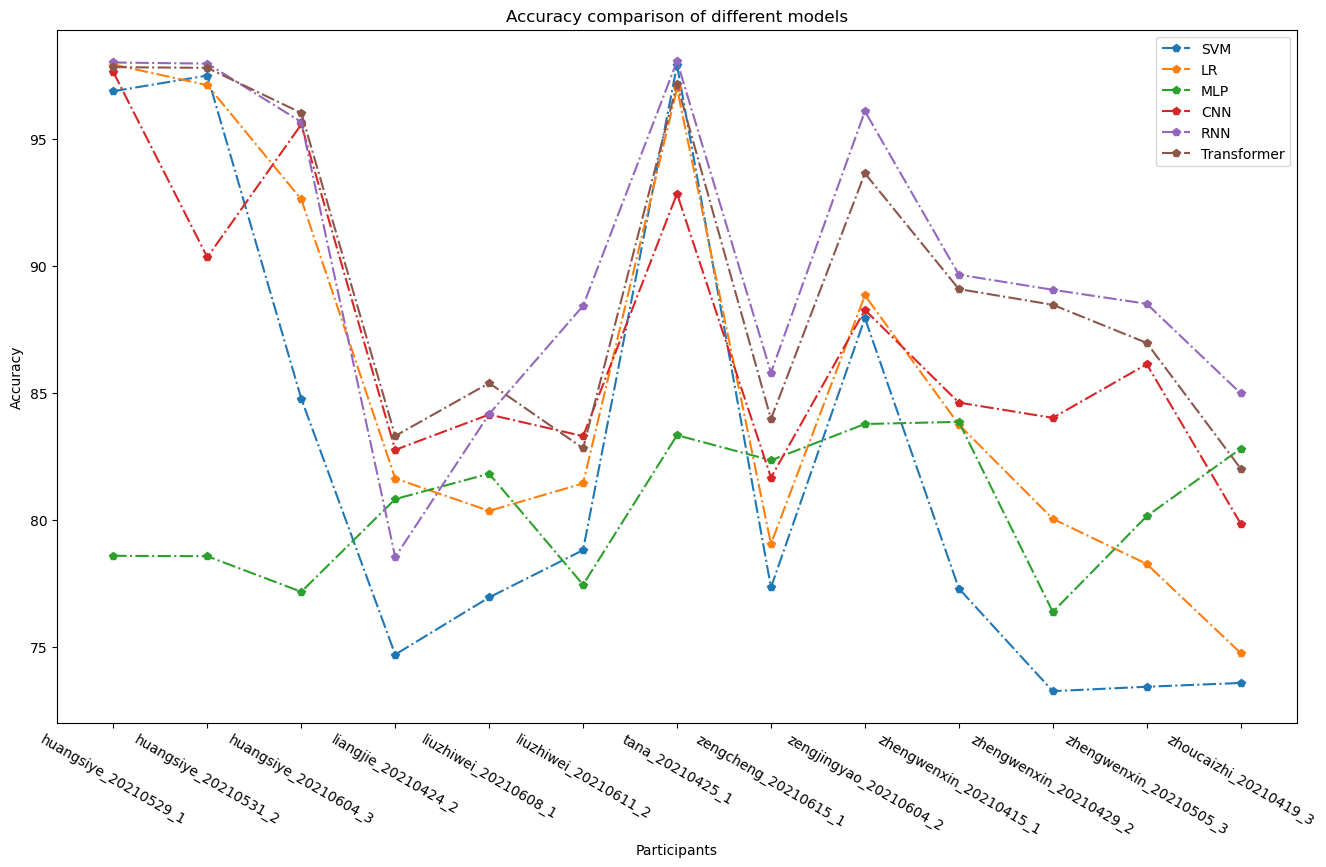

In [113]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
plt.title("Accuracy comparison of different models")
x = os.listdir(data_path)
plt.plot(x, acc_tests_SVM, '-.p')
plt.plot(x, acc_tests_LR, '-.p')
plt.plot(x, acc_tests_MLP, '-.p')
plt.plot(x, acc_tests_CNN, '-.p')
plt.plot(x, acc_tests_RNN, '-.p')
plt.plot(x, acc_tests_Transformer, '-.p')
plt.legend(['SVM','LR','MLP','CNN','RNN','Transformer'])
plt.show()

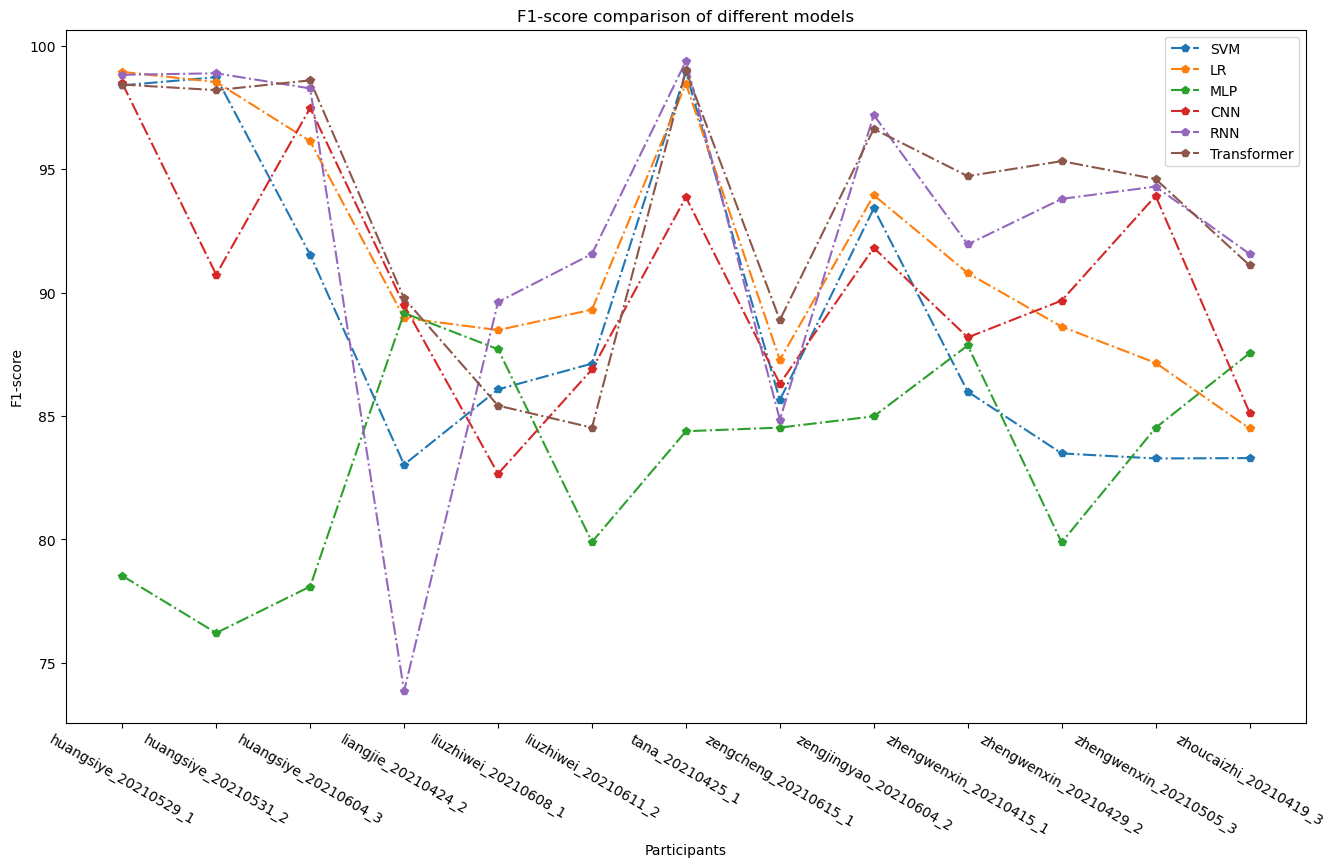

In [114]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('F1-score')
plt.title("F1-score comparison of different models")
x = os.listdir(data_path)
plt.plot(x, f1_tests_SVM, '-.p')
plt.plot(x, f1_tests_LR, '-.p')
plt.plot(x, f1_tests_MLP, '-.p')
plt.plot(x, f1_tests_CNN, '-.p')
plt.plot(x, f1_tests_RNN, '-.p')
plt.plot(x, f1_tests_Transformer, '-.p')
plt.legend(['SVM','LR','MLP','CNN','RNN','Transformer'])
plt.show()

[82.33654903100684, 85.59895017537063, 80.54501919406434, 87.00962290551237, 90.37669687136321, 89.57419862174864]
[9.233779752924145, 7.7584163541260915, 2.5635110815171065, 5.317762307210219, 6.034803983321749, 5.884959577679801]


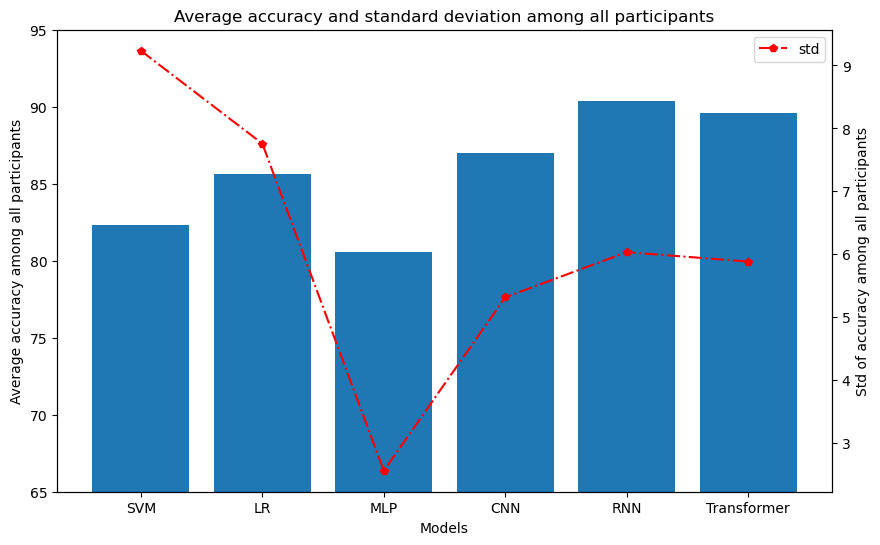

In [115]:
average = [np.mean(acc_tests_SVM), np.mean(acc_tests_LR), np.mean(acc_tests_MLP), 
           np.mean(acc_tests_CNN), np.mean(acc_tests_RNN), np.mean(acc_tests_Transformer)]
std = [np.std(acc_tests_SVM), np.std(acc_tests_LR), np.std(acc_tests_MLP), 
       np.std(acc_tests_CNN), np.std(acc_tests_RNN), np.std(acc_tests_Transformer)]
models = ['SVM','LR','MLP','CNN','RNN','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average accuracy among all participants')
ax1.set_ybound(65, 95)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of accuracy among all participants')
# ax2.set_ybound(2.0, 10.0)
plt.title("Average accuracy and standard deviation among all participants")
plt.legend(['std'])
fig.show()

[89.14908783471725, 91.62482770151284, 83.33251490983449, 90.35722855309899, 92.62014863879493, 93.47874820258882]
[6.018153063150513, 4.767245847728322, 4.142901795909847, 4.512869474040246, 6.819974962935381, 4.84445414154183]


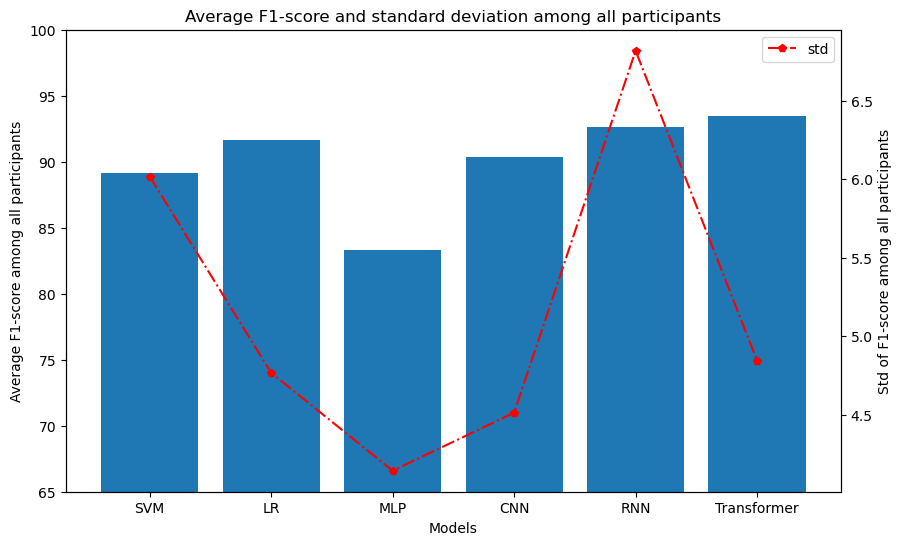

In [116]:
average = [np.mean(f1_tests_SVM), np.mean(f1_tests_LR), np.mean(f1_tests_MLP), 
           np.mean(f1_tests_CNN), np.mean(f1_tests_RNN), np.mean(f1_tests_Transformer)]
std = [np.std(f1_tests_SVM), np.std(f1_tests_LR), np.std(f1_tests_MLP), 
       np.std(f1_tests_CNN), np.std(f1_tests_RNN), np.std(f1_tests_Transformer)]
models = ['SVM','LR','MLP','CNN','RNN','Transformer']
print(average)
print(std)
fig, ax1 = plt.subplots(figsize = (10,6))
ax1.bar(models, average)
ax1.set_xlabel('Models')
ax1.set_ylabel('Average F1-score among all participants')
ax1.set_ybound(65, 100)
ax2 = ax1.twinx()
ax2.plot(models, std, '-.p', color = 'red')
ax2.set_ylabel('Std of F1-score among all participants')
# ax2.set_ybound(2.0, 10.0)
plt.title("Average F1-score and standard deviation among all participants")
plt.legend(['std'])
fig.show()